In [11]:
# this project analyzes the kaggle telco customer churn dataset to identify key drivers behind
# customer attrition. the goal is to help figure out which types of customers churn the most,
# what services correlate with higher churn, and how charges and tenure relate to churn.
# additionally, this project will tell us which customers should be prioritized for retention
# programs.
# this project will focus on data cleaning, exploratory data analysis, segmentation, visualization,
# as well as business insights

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
from matplotlib.ticker import PercentFormatter


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

df = pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

df_clean = df

# checking what the non numeric values of 'Total Charges' are
# they are blank spaces and all the customers have a '0' for tenure, so they are new customers
# who have yet to be charged.
# these customers don't have a meaningful billing history and thus can be safely excluded
df['TotalCharges'] = df['TotalCharges'].str.strip()
df['TotalCharges'] = df['TotalCharges'].replace("", np.nan)
df = df.dropna(subset=['TotalCharges']).copy()
df['TotalCharges'] = df['TotalCharges'].astype(float)


df = df.drop(columns=['customerID'])

df['ChurnBinary'] = df['Churn'].map({'Yes': 1, 'No': 0})
df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

# i'm choosing to replace 'no internet' customers in the internet_features category to 'no' because
# including them is misrepresenting the data. i'm choosing to replace it rather than remove it
# in order to keep a consistent sample size

internet_features = [
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]

for col in internet_features:
    df[col] = df[col].replace({'No internet service': 'No'})


# customers who do not have multiple lines. "No phone service" indicates the customer has no 
# phone plan at all, which makes them functionally equivalent to customers with only one line 
# for the purpose of this feature. 
# 
# Keeping them separate would incorrectly treat "No phone service" as a meaningful category 
# within the MultipleLines feature, even though it falls outside the definition of the variable. 
# This is a standard and logically necessary cleaning step, independent of the churn rates.
# Additionally, a difference in churn rate of <.001 was observed between no service and no multiple
# lines

df['MultipleLines'] = df['MultipleLines'].replace({
    'No phone service': 'No'
})


df.info()
df.head()

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv
<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   object 
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ChurnBinary
0,Female,No,Yes,No,1,No,No,DSL,No,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,0
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1
3,Male,No,No,No,45,No,No,DSL,Yes,No,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1


In [12]:
from scipy.stats import chi2_contingency

def categoricalDataSummary(df, col):
    churn_rates = df.groupby(col)['ChurnBinary'].mean()
    contingency = pd.crosstab(df[col], df['Churn'])
    chi2, p, dof, expected = chi2_contingency(contingency)

    return {
        "feature": col,
        "min_churn": churn_rates.min(),
        "max_churn": churn_rates.max(),
        "churn_gap": churn_rates.max() - churn_rates.min(),
        "p_value": p
    }
categoricalData = ['gender',
                   'SeniorCitizen',
                   'Partner',
                   'Dependents',
                   'PhoneService',
                   'MultipleLines',
                   'InternetService',
                   'OnlineSecurity',
                   'OnlineBackup',
                   'TechSupport',
                   'StreamingTV',
                   'StreamingMovies',
                   'Contract',
                   'PaperlessBilling',
                   'PaymentMethod']



This section set up the analysis for the categorical data.

In [13]:
from statsmodels.stats.multitest import multipletests

summary_rows = [categoricalDataSummary(df, col) for col in categoricalData]
summary_df = pd.DataFrame(summary_rows)

# FDR (Benjamini–Hochberg) correction
summary_df['corrected_p'] = multipletests(
    summary_df['p_value'],
    method='fdr_bh'
)[1]
summary_df['Significant_corrected'] = summary_df['corrected_p'] < 0.05

summary_df = summary_df.sort_values('churn_gap', ascending=False)

# Use corrected significance for plotting
sig = summary_df[
    (summary_df["Significant_corrected"] == True) &
    (summary_df["churn_gap"] > 0.02)
]
print(sig)


             feature  min_churn  max_churn  churn_gap        p_value  \
12          Contract   0.028487   0.427097   0.398610  7.326182e-257   
6    InternetService   0.074342   0.418928   0.344586  5.831199e-159   
14     PaymentMethod   0.152531   0.452854   0.300323  1.426310e-139   
1      SeniorCitizen   0.236503   0.416813   0.180310   2.479256e-36   
13  PaperlessBilling   0.163757   0.335893   0.172136   8.236203e-58   
7     OnlineSecurity   0.146402   0.313733   0.167331   1.374240e-46   
9        TechSupport   0.151961   0.312300   0.160339   3.232868e-43   
3         Dependents   0.155312   0.312791   0.157479   2.019659e-42   
2            Partner   0.197171   0.329761   0.132590   3.973798e-36   
8       OnlineBackup   0.215670   0.292164   0.076494   6.259257e-12   
10       StreamingTV   0.243705   0.301147   0.057442   1.316434e-07   
11   StreamingMovies   0.244362   0.299524   0.055162   3.857900e-07   
5      MultipleLines   0.250677   0.286485   0.035808   8.694083

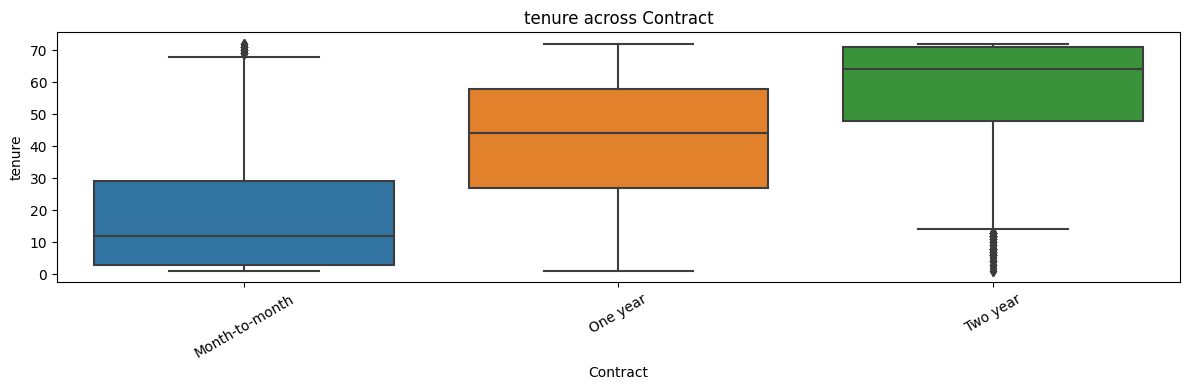

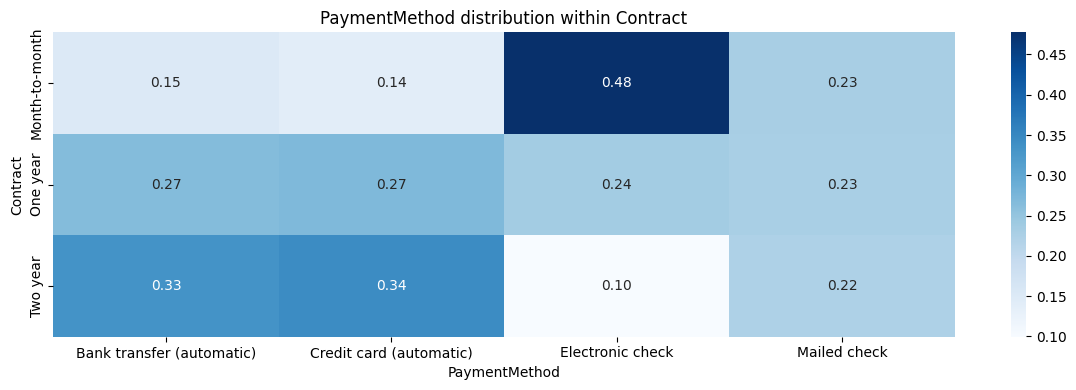

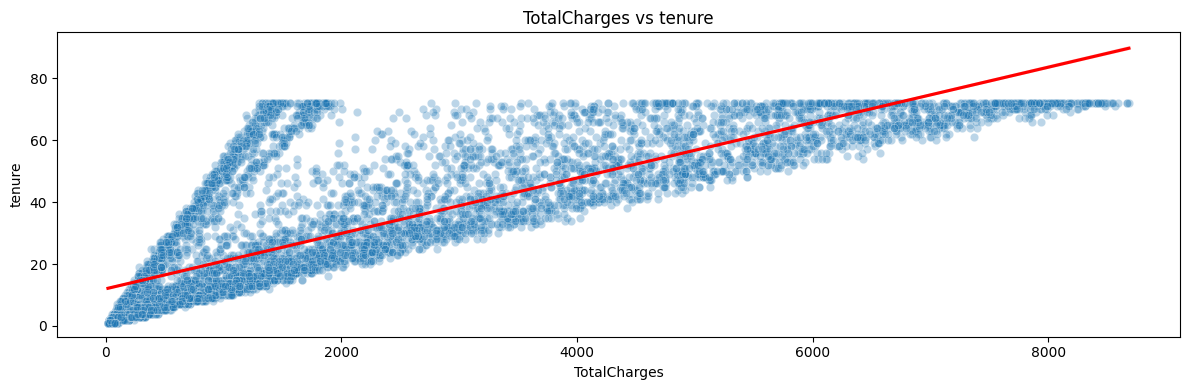

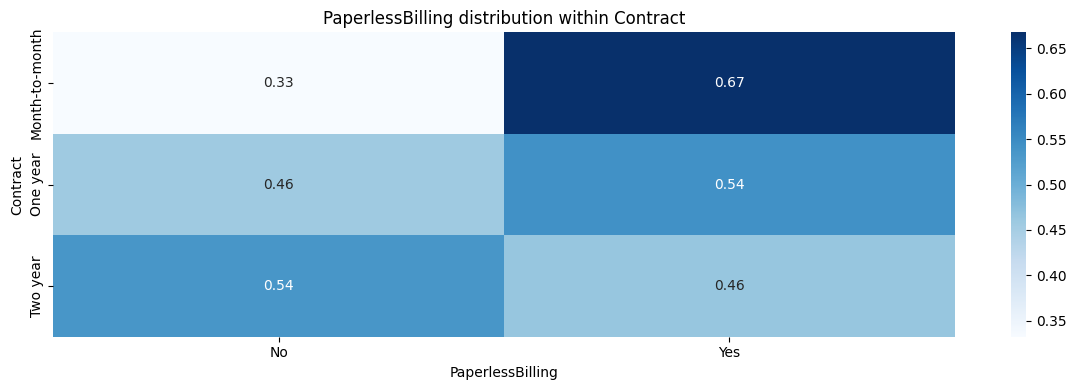

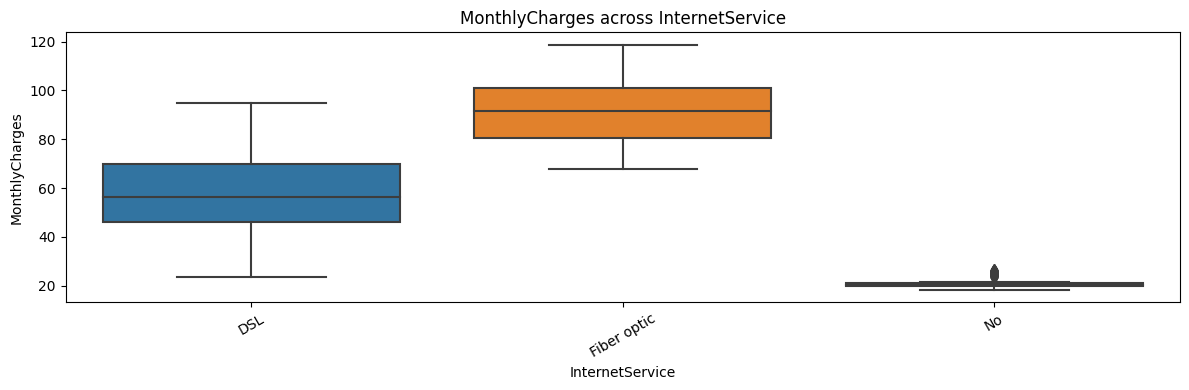

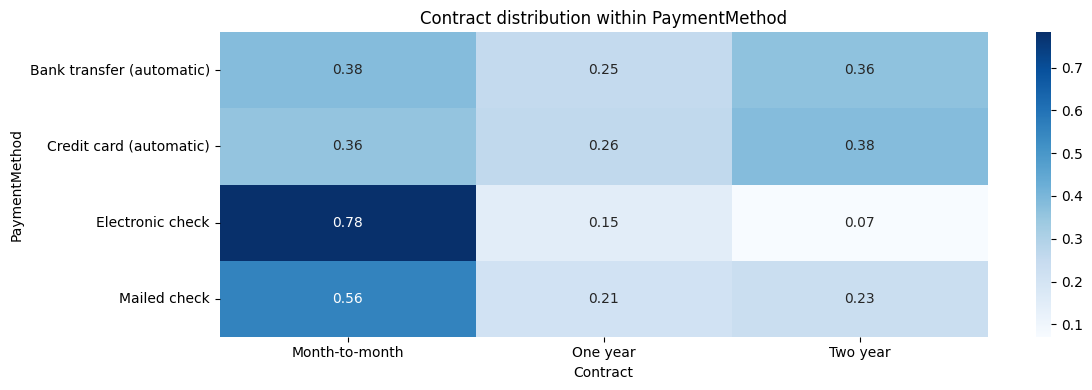

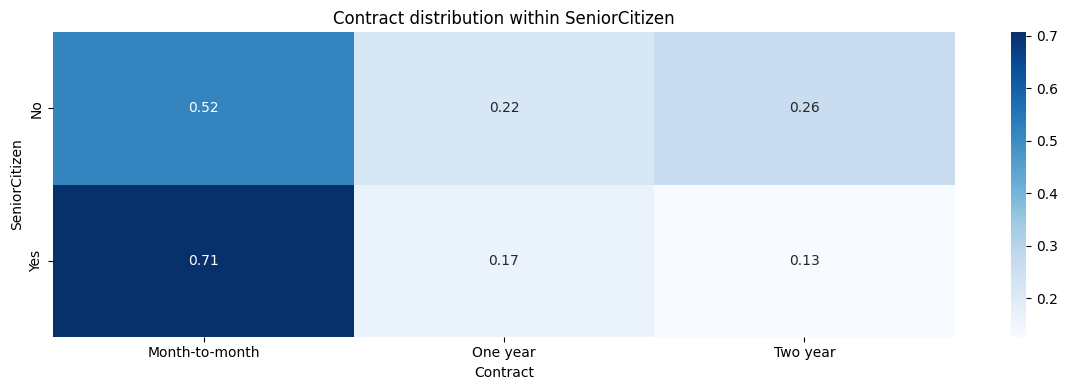

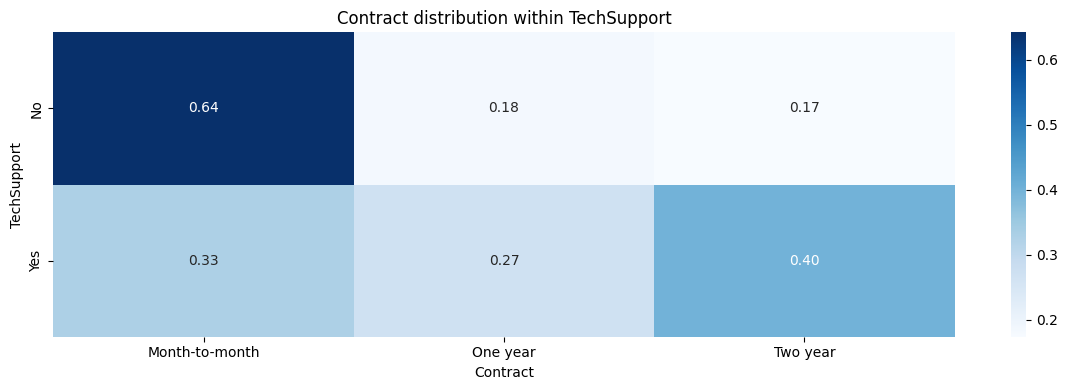

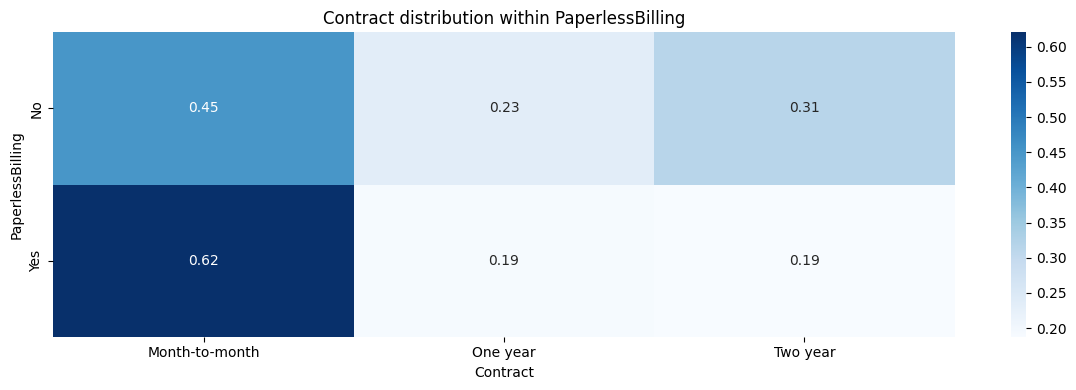

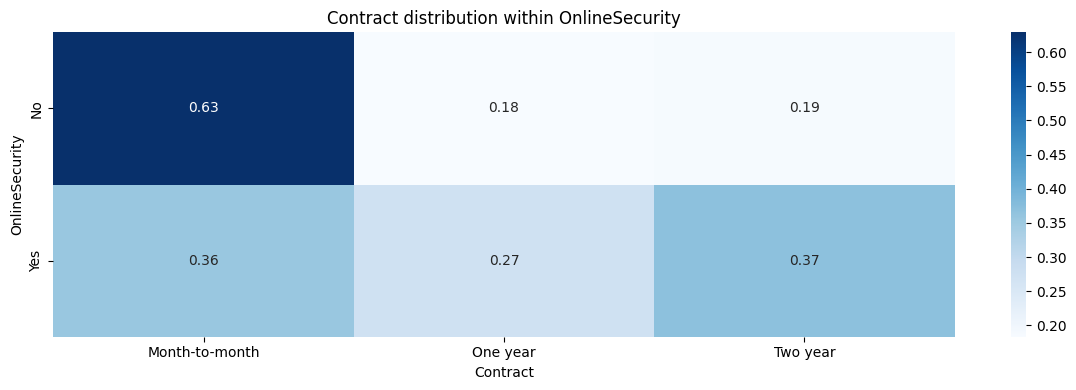

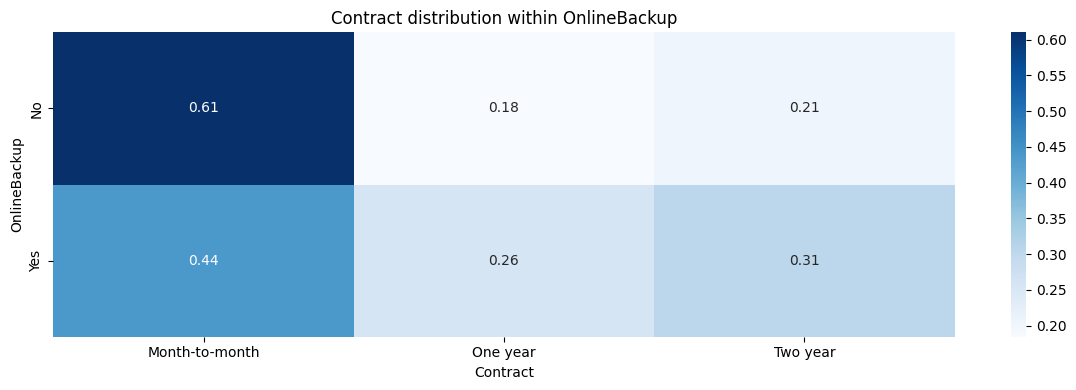

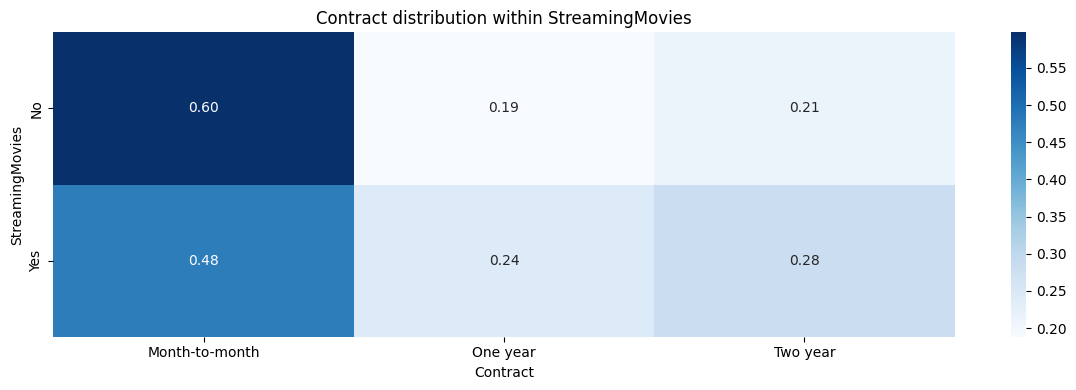

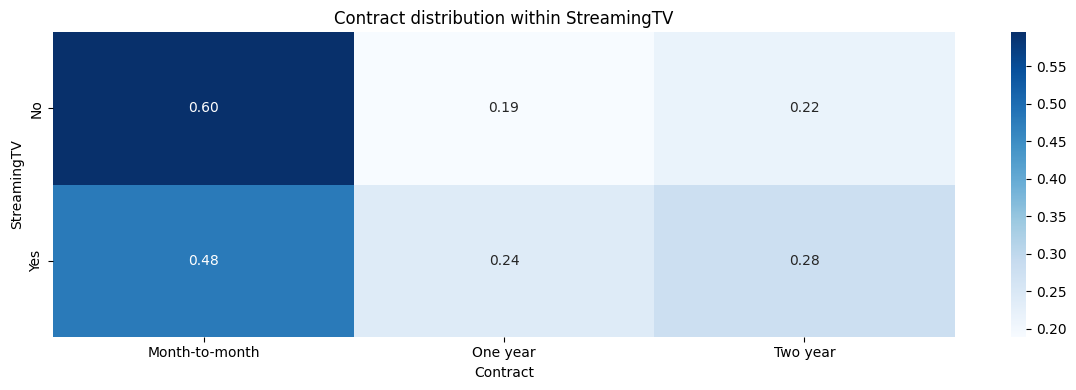

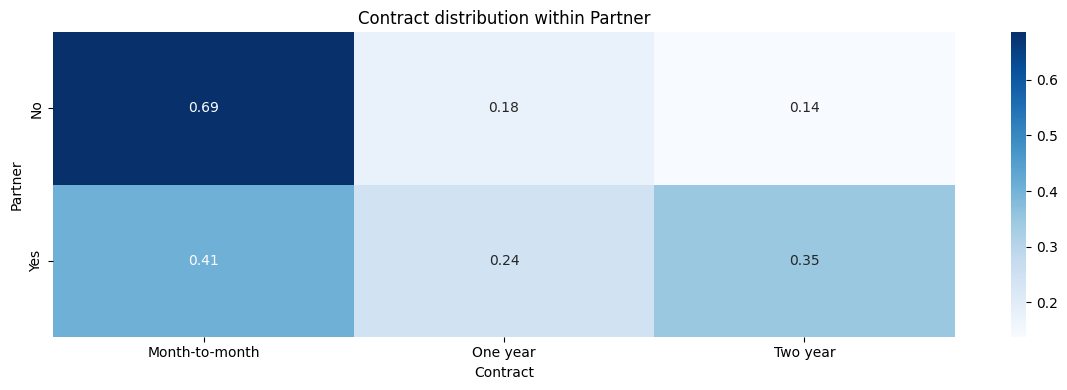

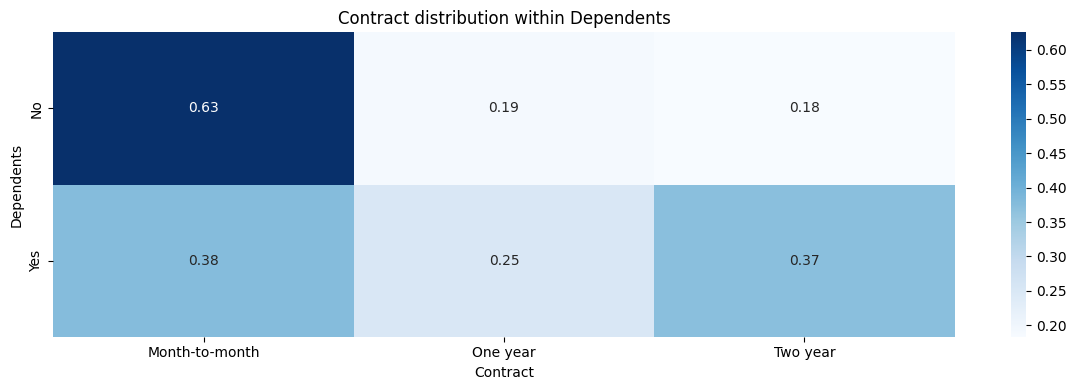

In [14]:
# checking interfeature relationship
# likely key relationships:
# contract and tenure
# contract and paymentmethod
# monthlycharges and internetservice
# totalcharges and tenure

interaction_pairs = [
    ('tenure', 'Contract', 'num_cat'),
    ('Contract', 'PaymentMethod', 'cat_cat'),
    ('TotalCharges', 'tenure', 'num_num'),
    ('Contract', 'PaperlessBilling', 'cat_cat'),
    ('MonthlyCharges', 'InternetService', 'num_cat'),
    ('PaymentMethod', 'Contract', 'cat_cat'),
    ('SeniorCitizen', 'Contract', 'cat_cat'),
    ('TechSupport', 'Contract', 'cat_cat'),
    ('PaperlessBilling', 'Contract', 'cat_cat'),
    ('OnlineSecurity', 'Contract', 'cat_cat'),
    ('OnlineBackup', 'Contract', 'cat_cat'),
    ('StreamingMovies', 'Contract', 'cat_cat'),
    ('StreamingTV', 'Contract', 'cat_cat'),
    ('Partner', 'Contract', 'cat_cat'),
    ('Dependents', 'Contract', 'cat_cat')
]

def plot_num_cat(df, num, cat):
    plt.figure(figsize=(12, 4))
    sns.boxplot(data=df, x=cat, y=num)
    plt.title(f"{num} across {cat}")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

def plot_cat_cat(df, col1, col2):
    ct = pd.crosstab(df[col1], df[col2], normalize="index")
    plt.figure(figsize=(12, 4))
    sns.heatmap(ct, annot=True, fmt=".2f", cmap="Blues")
    plt.title(f"{col2} distribution within {col1}")
    plt.tight_layout()
    plt.show()

def plot_num_num(df, col1, col2):
    plt.figure(figsize=(12, 4))
    sns.scatterplot(data=df, x=col1, y=col2, alpha=0.3)
    sns.regplot(data=df, x=col1, y=col2, scatter=False, color="red")
    plt.title(f"{col1} vs {col2}")
    plt.tight_layout()
    plt.show()

for col1, col2, kind in interaction_pairs:
    if kind == "num_cat":
        plot_num_cat(df, num=col1, cat=col2)
    elif kind == "cat_cat":
        plot_cat_cat(df, col1, col2)
    elif kind == "num_num":
        plot_num_num(df, col1, col2)


**Tenure and Contract**

Tenure increases dramatically for longer contract types. This means that the contract length and customer maturity are tightly linked: if a custmomer has a 2 year contract, they are likely long term customers. This dependency needs to be accounted for when interpreting churn drivers.

**Payment Method and Contract Type**

What sticks out here is the correlation between electronic check and month-to-month contracts. Nearly half of the month to month customers are paying by electronic check. It will be important to note that if electronic checks have a high churn rate it might be because of the month-to-month customers.

**Total Charges and Tenure**

while a few customers seem to be following a premium plan, there are basically no outliers in the analysis that total charges increase with tenure. This means that rather than the total charges being the cause of churn it may be the tenure.

**Paperless Billing and Contract Type**

There's a very strong correlation between month to month contracts and paperless billing. this is important because aside from those short term customers whose churn rates are already high. The one year and two year customers seem split 50/50 between paperless and paper billing.


**Internet Service and Price**

There is a strong correlation with the type of internet service the customer receives and the price.

**Payment Method and Contract Type**

There is a very strong relation ship between month to month customers and electronic checks. they make up a vast majority of all electronic check payments (78%)

**Senior Citizen and Contract Type**

A majority (71%) of senior citizens are on a month to month contract. Contract type may be a confounding variable for any analysis done on senior citizens.

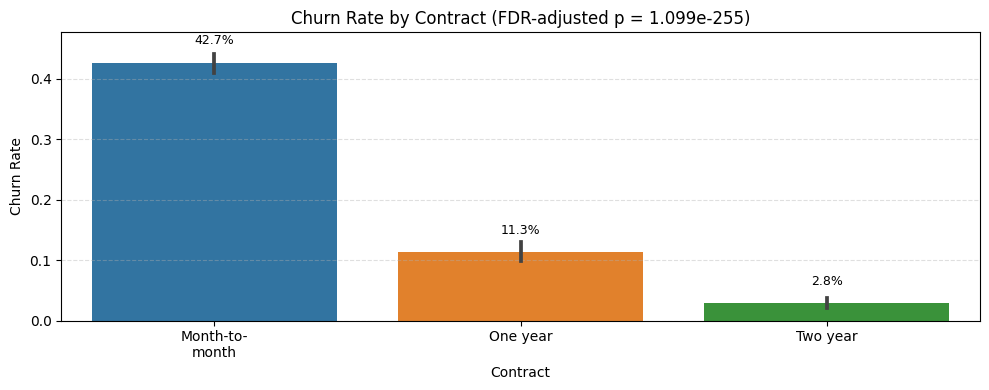

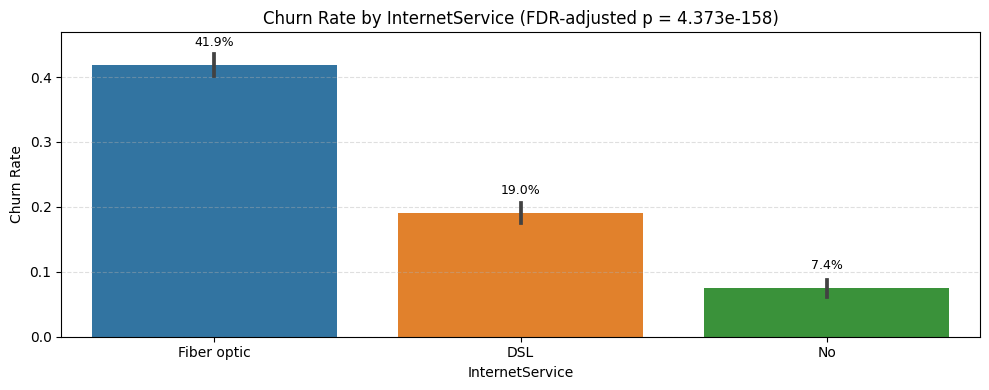

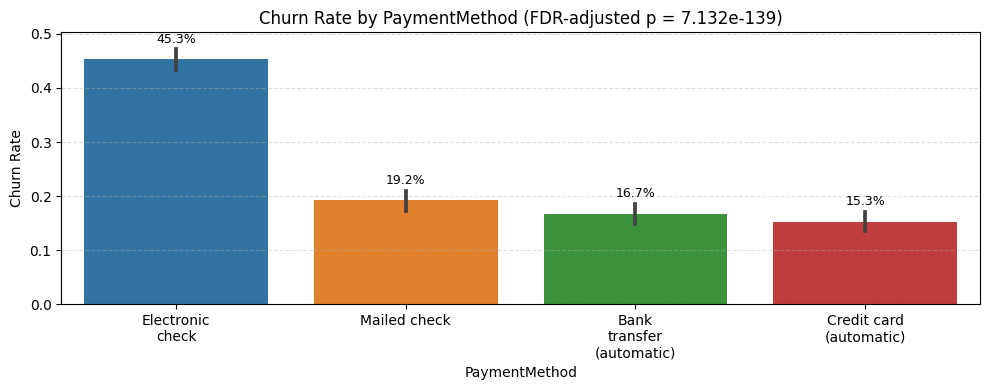

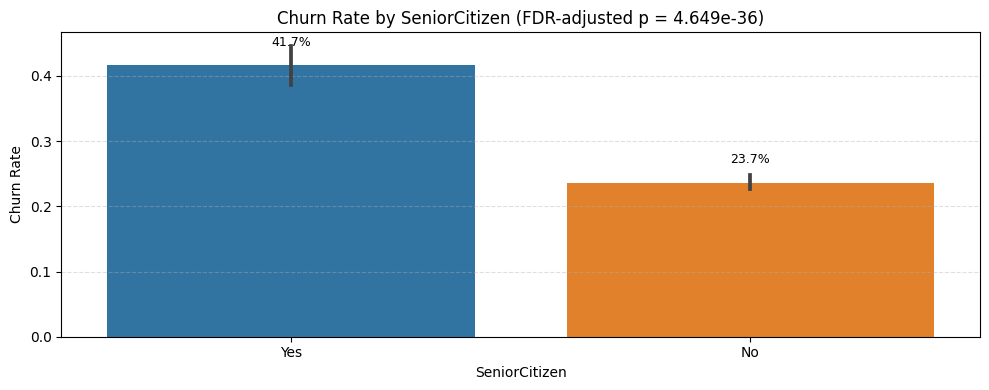

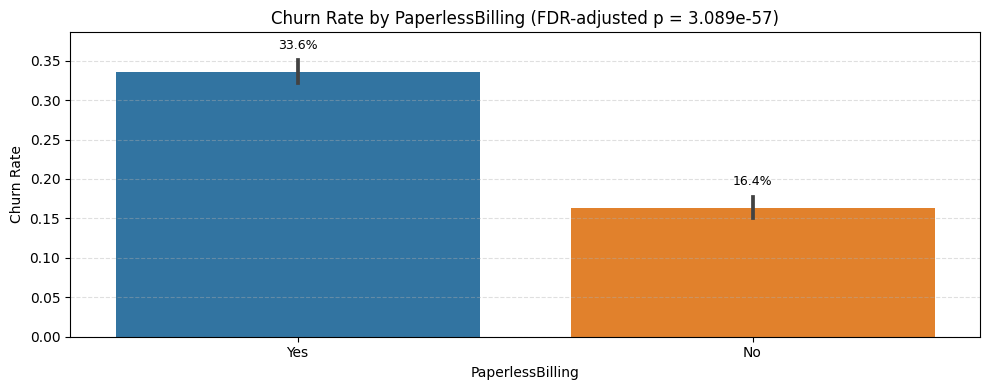

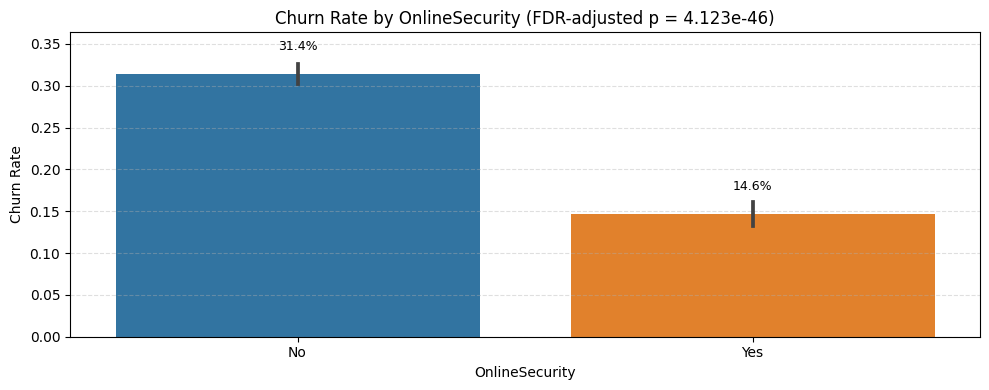

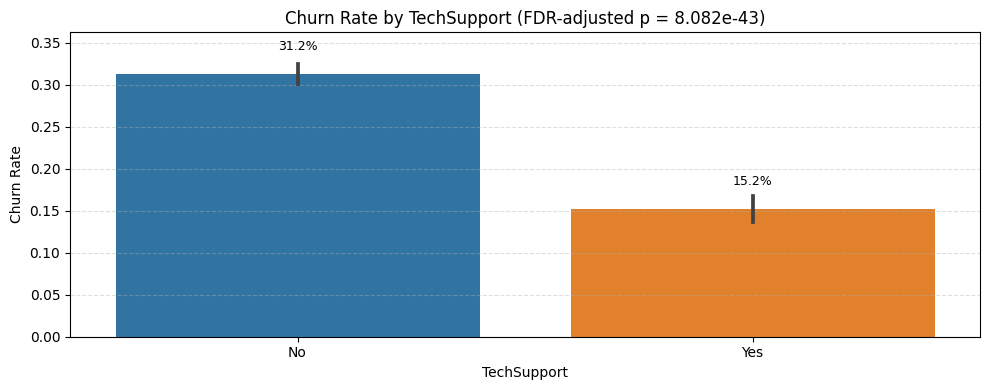

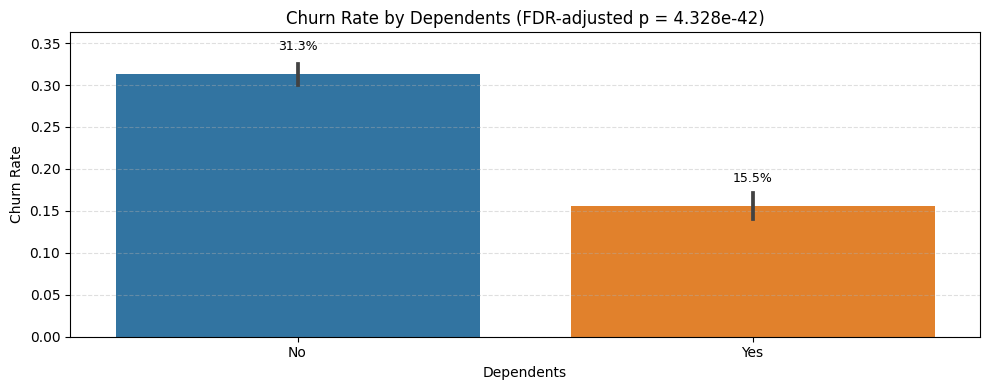

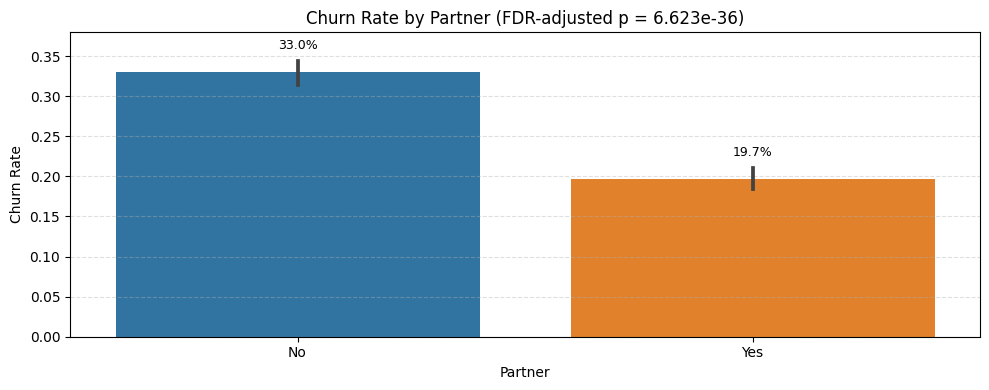

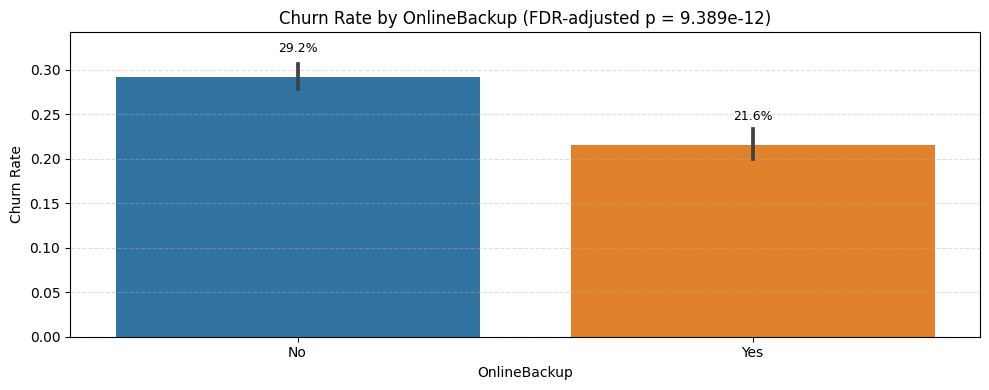

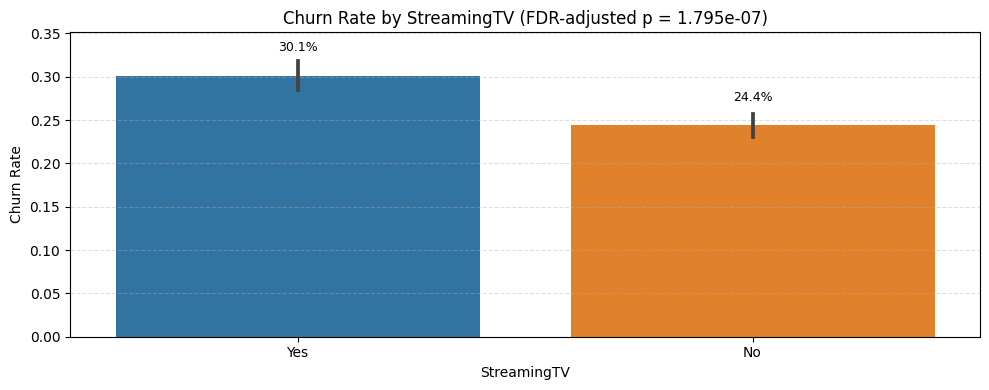

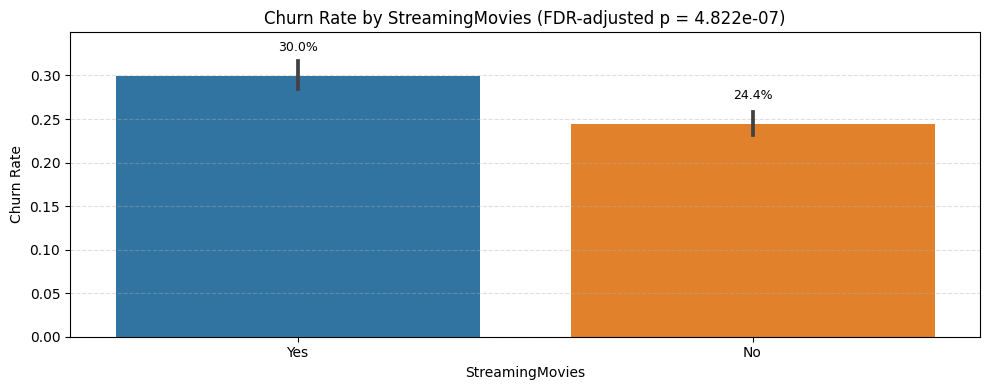

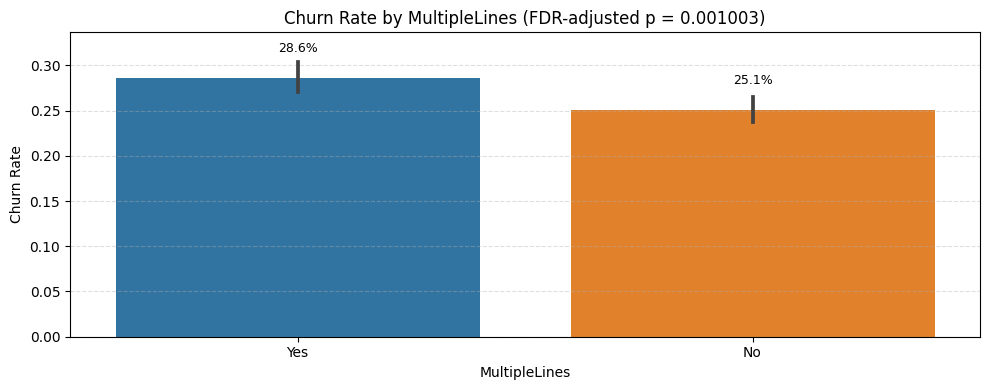

In [15]:
# building functions to graph significant contributors to churn rate

def plot_churn_rate(df, col, p_adj, order=None):
    churn_rates = df.groupby(col)['ChurnBinary'].mean()

    # Order categories by churn rate if not provided
    if order is None:
        order = churn_rates.sort_values(ascending=False).index
    else:
        churn_rates = churn_rates.reindex(order)

    fig, ax = plt.subplots(figsize=(10, 4))
    plt.grid(axis='y', linestyle='--', alpha=0.4)

    # seaborn will compute the mean of ChurnBinary by category
    sns.barplot(data=df, x=col, y='ChurnBinary', order=order, ax=ax)

    # Add percentage labels above each bar
    for patch in ax.patches:
        height = patch.get_height()
        ax.text(
            patch.get_x() + patch.get_width() / 2,
            height + 0.025,              # slightly above the bar
            f"{height * 100:.1f}%",     # convert to %
            ha='center', va='bottom',
            fontsize=9
        )


    ax.set_title(f"Churn Rate by {col} (FDR-adjusted p = {p_adj:.4g})")
    ax.set_ylabel("Churn Rate")
    ax.set_xlabel(col)

    ax.set_ylim(0, churn_rates.max() + 0.05)

    new_labels = [
        '\n'.join(textwrap.wrap(lbl.get_text(), width=12))
        for lbl in ax.get_xticklabels()
    ]
    ax.set_xticklabels(new_labels, rotation=0, ha='center')

    fig.tight_layout()
    plt.show()


for _, row in sig.iterrows():
    col = row["feature"]
    plot_churn_rate(df, col, row["corrected_p"])


**Contract**

Month to month contracts churned at a rate of 42.7%, compared with 11% for 1 year contracts and 3% for 2 year contracts. Thi makes month to month customers churn at a rate of nearly 4x the rate of 1 year contracts. Shorter contracts are associated with lower customer commitment and higher switching behavior. Retention efforts should prioritize month to month contracts and incentives to move them to longer term contracts could meaningfully reduce churn.

**Internet Service**

Fiber optic internet churned at a rate of 41.9%, compared to 19% for DSL and 7.4% for customers with no internet service. Fiber optic customers churn at a rate over double that of DSL and nearly 6 times that of customers without internet service. This pattern is largely explained by higher monthly charges among fiber optic customers. As we will see later, churn tends to increase with price. While the difference in churn rates is substantial, it is important to note that action based on price related pain points may be more effective than the action based on the actual service (ie reducing the price of fiber optic).

**Payment Method**

Electronic check churned at a rate of 45.3%, compared to 19.2% for mailed check, 16.7% for automatic bank transfer, and 15.3% for automatic credit card payments. The electronic check churns at a rate over double of mailed check, and mailed check has a slightly higher churn rate than the two automatic payment methods. However, this is largely explained by the payment method's relationship to the contract. A majority of the electronic check customers (78%), and over half of mailed customers are month-to-month customers. This suggests the difference in churn rate doesn't actually lie in the difference in payment methods but contract types. Focusing efforts based on payment method is unlikely to meaningfully reduce churn.

**Senior Citizen**

Senior citizens churn at a rate of 41.7% while nonsenior citizens churn at a rate of 23.7%. This is again largely explained by the fact that a disporportionate amount of seniors are on a month to month (71%) plan rather than an annual or biannual plan. Encouraging seniors towards long term contracts with things like senior discounts may meaningfuly reduce churn in this segment.

**Paperless Billing**

Customers with paperless billing churn at a rate of 33.6% compared to non-paperless billing churning at a rate of 16.4%. This again seems significant until you look at the relationship between paperless billing and contract. A disproportionate amount of month to month users (67%) are using paperless billing

**Online Services**

The use of any additional online service (tech support, streaming movies, streaming tv, online backup, online security). The most significant feature being tech support. The churn rates for those with tech support being 15.2% and those without being 31.2%(nearly double), but this is largely explained by the fact that 64% of people without techsupport are on month to month contracts. Those with one year and two year contracts both have higher rates of tech support. This trend continues with onliine security, online backup, and both streaming services.

**Partner and Dependents**

Having a partner and denpendents seems to reduce churn rate when those with dependents churn at a rate of 15.5% while those without churn at a rate of 31.3%. Similarly, those with partners churn at a rate of 19.7% while those without churn at a rate of 33%. This seems significant until looking at the relationship with contract type. 69% of those without partners and 63% of those without dependents have month to month contracts. That being said, it may be worth advertising towards families to attract customers that are more inclined to sign longer term contracts.


**Multiple Lines**

People with multiple lines have a slightly lower churn rate. That being said, it's difficult to encourage people to get additional lines they don't need and the difference is minimal. While the difference in churn rates is worth noting, any immediate action is low priority.



In [16]:
from scipy.stats import mannwhitneyu
from scipy.stats import pointbiserialr

def numericDataSummary(df, col):
    # separate the column into churned and non-churned groups
    churned = df.loc[df['ChurnBinary'] == 1, col]
    notChurned = df.loc[df['ChurnBinary'] == 0, col]

    # Mann–Whitney U test
    u_stat, p_val = mannwhitneyu(
        churned,
        notChurned,
        alternative='two-sided'
    )

    # Point-biserial correlation
    corr, p_corr = pointbiserialr(df[col], df['ChurnBinary'])

    return {
        "feature": col,
        "mean_churned": churned.mean(),
        "mean_not_churned": notChurned.mean(),
        "u_stat": u_stat,
        "p_mannwhitney": p_val,
        "corr": corr,
        "p_corr": p_corr
    }

def numericPlots(df, col):
    fig, axes = plt.subplots(2, 1, figsize = (10, 8), sharex = False)
    sns.histplot(
        data=df,
        x=col,
        hue='Churn',
        kde=True,
        stat='density',
        common_norm=False,
        ax=axes[0]
    )
    axes[0].set_title(f'Distribution of {col} by Churn Status')
    axes[0].set_ylabel('Density')
    axes[0].grid(True, alpha=0.3)
    sns.boxplot(
        data=df,
        x='Churn',
        y=col,
        ax=axes[1]
    )
    axes[1].set_title(f'{col} by Churn Status')
    axes[1].set_xlabel('Churn')
    axes[1].set_ylabel(col)
    axes[1].grid(True, axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

numericData = ['tenure', 'MonthlyCharges', 'TotalCharges']

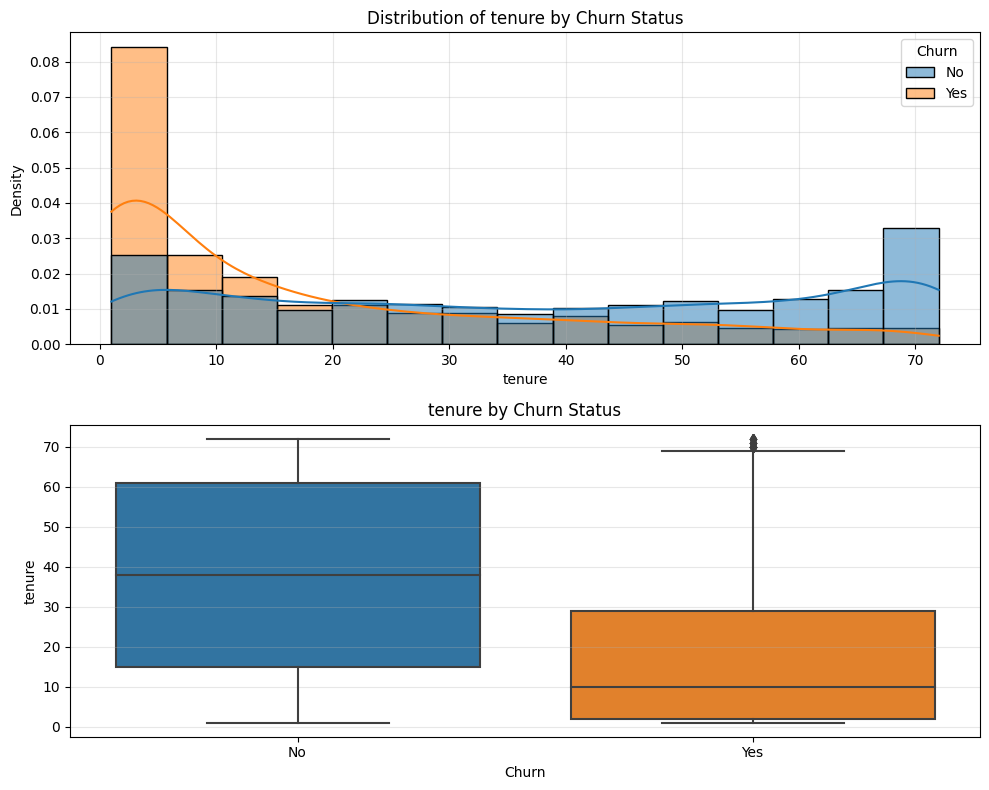

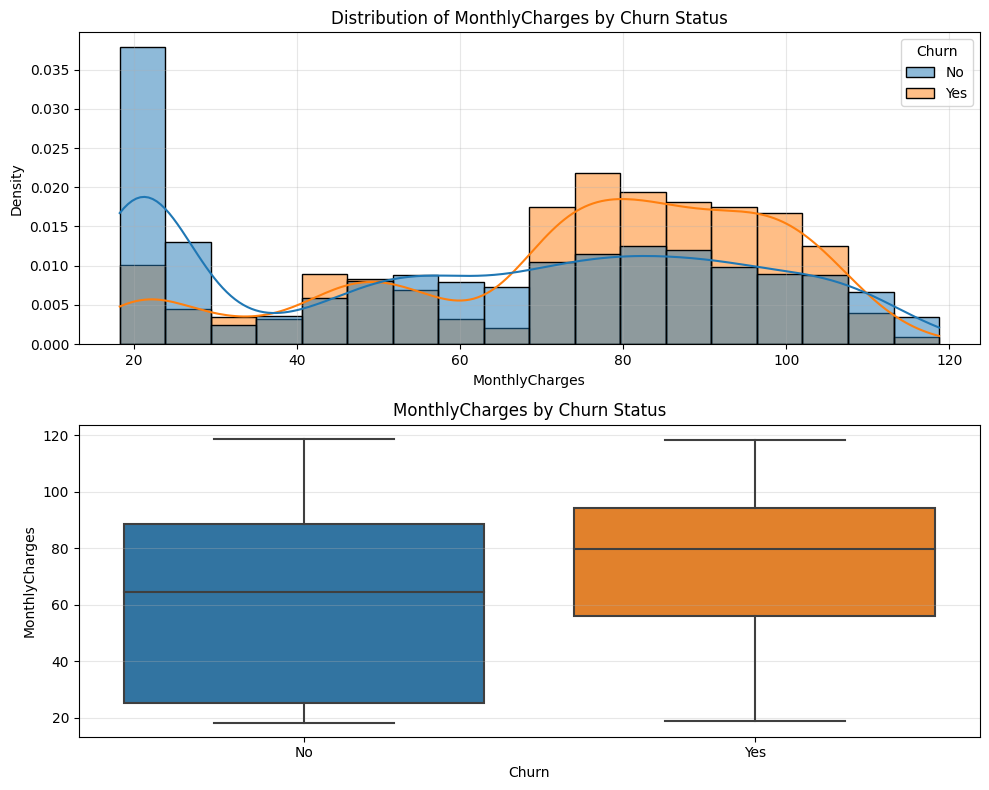

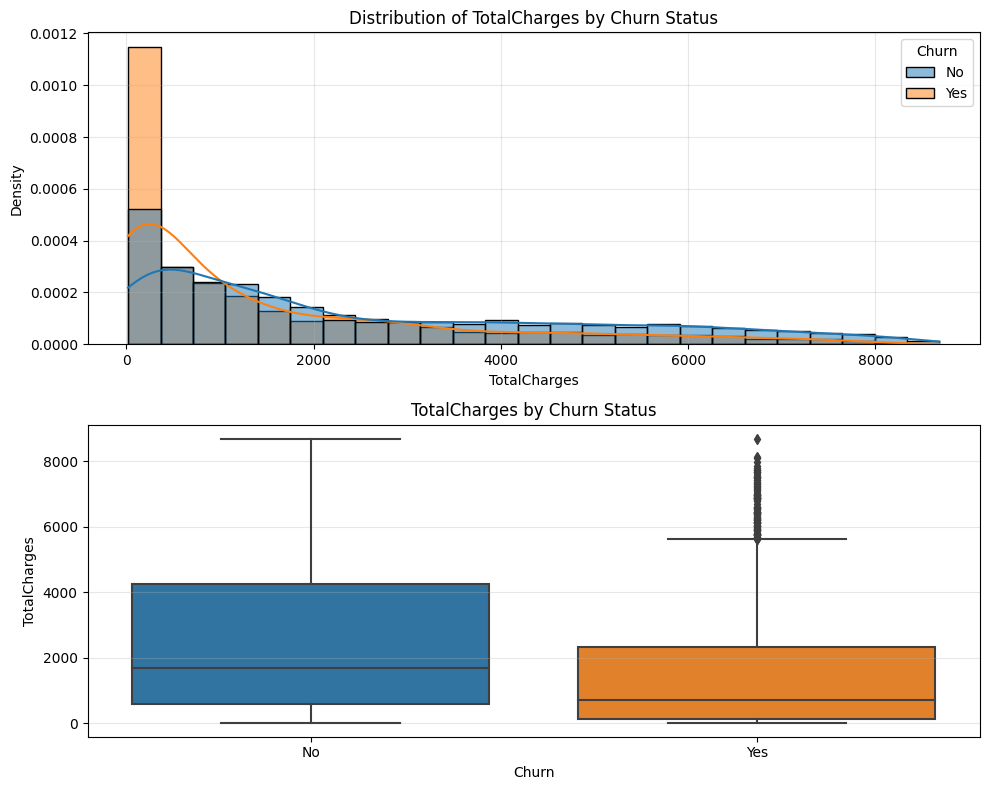

In [17]:
from sklearn.linear_model import LinearRegression

import warnings

warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    module="seaborn"
)


for col in numericData:
    numericDataSummary(df, col)
    numericPlots(df, col)

**Tenure**

The churn rate is the highest among the newest customers (less than six months). After this, the churn rate declines almost linearly as tenure increases and becomes very low among the long-term customers. The median tenure among churned customers is significantly lower than that of retained customers, reflecting a strong negative relationship between tenure and churn.
A Mann–Whitney test confirms a statistically significant difference in tenure between churned and retained customers, and the strong negative correlation indicates that tenure is one of the most powerful predictors of churn in the dataset.

**Monthly Charges**

Churn rates are lowest among customers paying the lowest monthly charges. As charges increase, churn rises steadily, with the highest churn occurring among customers paying roughly $70–$100 per month. This pattern is driven by the fact that higher charges often correspond to premium internet plans, additional online services, and a greater concentration of month-to-month customers; all factors associated with higher churn. Although customers paying the very highest prices are fewer in number, the overall relationship between price and churn remains clear: higher monthly charges are strongly associated with increased churn, making pricing pressure an important factor to consider in retention efforts.

**Total Charges**

There is a very clear inverse relationship between total charges and churn rates. Customers with low total charges churn at much higher rates, and churn steadily declines as total charges increase. This pattern aligns with the tenure analysis: the longer someone has been a customer, the more they have spent, and long-tenured customers churn far less. One thing that is important to note, however, is that total charges is strongly dependent on tenure. In the earlier analysis, we saw a near-perfect linear relationship between the two, meaning the true driver is almost certainly tenure, not total charges itself.

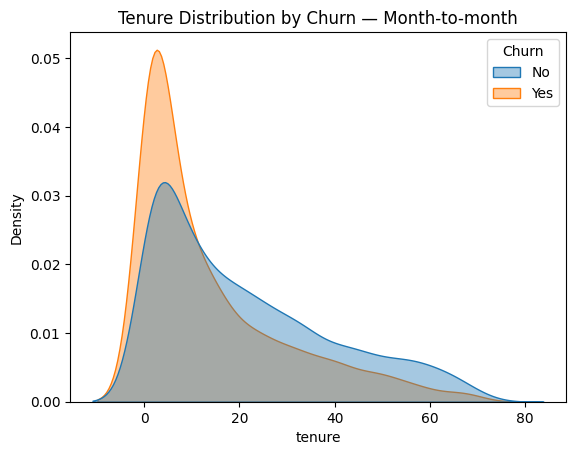

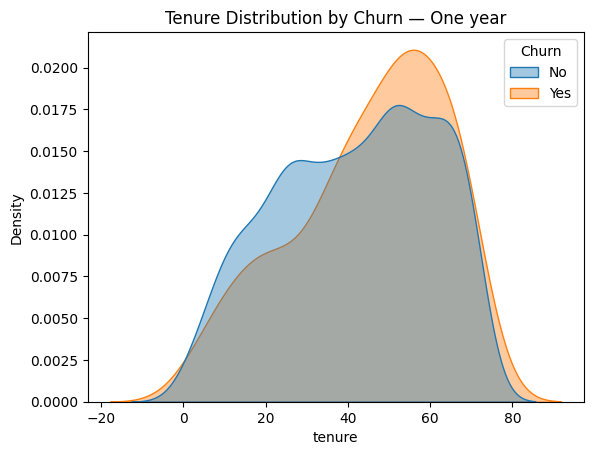

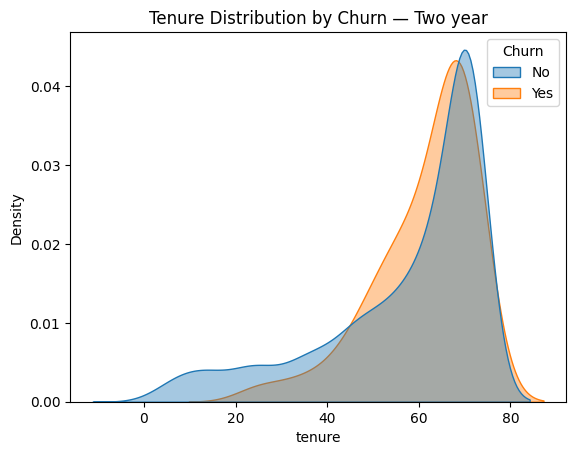

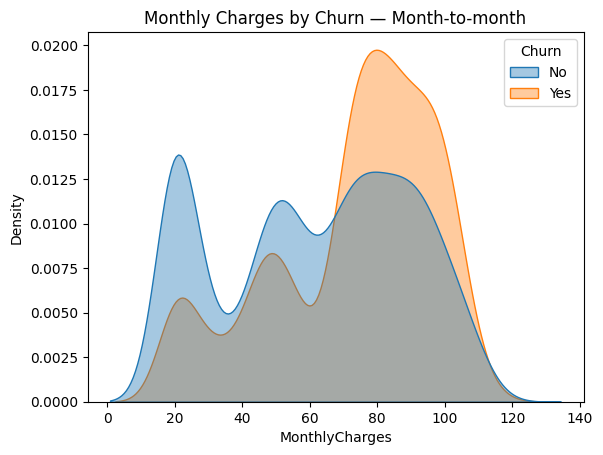

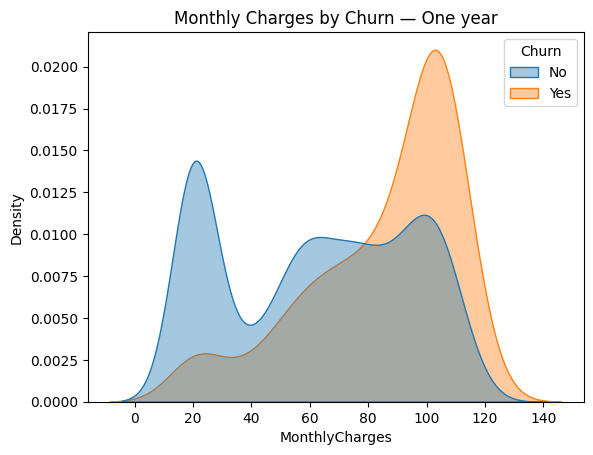

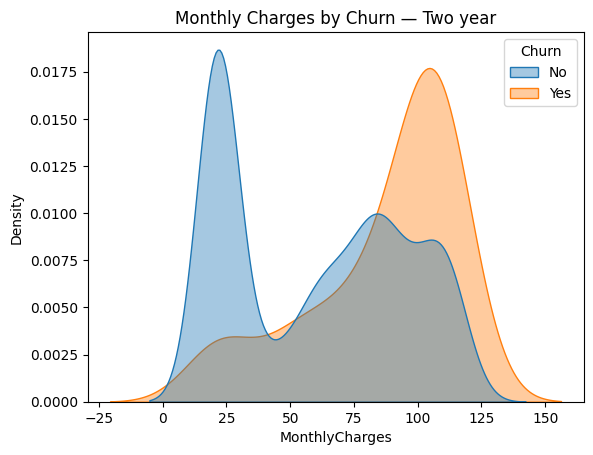

In [18]:
for contract in df['Contract'].unique():
    subset = df[df['Contract'] == contract]
    sns.kdeplot(
        data=subset,
        x='tenure',
        hue='Churn',
        fill=True,
        common_norm=False,
        alpha=0.4
    )
    plt.title(f"Tenure Distribution by Churn — {contract}")
    plt.show()

for contract in df['Contract'].unique():
    subset = df[df['Contract'] == contract]
    sns.kdeplot(
        data=subset,
        x='MonthlyCharges',
        hue='Churn',
        fill=True,
        common_norm=False,
        alpha=0.4
    )
    plt.title(f"Monthly Charges by Churn — {contract}")
    plt.show()


These graphs show that the numerical data are strong predictors of churn. While tenure is not independent of contract type it is still providing important insight. Monthlycharges, however, is partially independent of contract type. Contract affects it, but price still predicts churn within each contract type.

**Summary**

This analysis yielded the key features that are associated with churn in the Telco dataset. There were many variables that initially appeared to affect churn, most of those relationships were explained by confounding variables (typically contract type). After accounting for these confounding effects, three variables emerged as strong drivers of churn: contract type, tenure, and monthly charges.

Contract type is the primary predictor of churn. Month to month customers churned at a rate of 42.7% compared to 11.3% for one year and 2.8% for two years. Many other predictors that appeared important (payment method, paperless billing, online services, senior status etc) became insignificant once their relationships with contract was discovered. In most cases, high churn within a category was explained by that group being heavily concentrated among month to month customers, not because the variable itself was causing churn.

Tenure is also a powerful predictor. Customers with less than six months churned at extremely high rates and after that initially high rate, churn decreased almost linearly as tenure increased. We use tenure despite its relationship with contract type because it is an accurate predictor within contract types.

The last real predictor is monthly charges. Churn increases steadity with monthly charges, peaking between 70 and 100 dollars per month. This relationship persists even after accounting for contract type, indicating that higher prices lead directly to higher churn.



**Reccomendations**

The top priority is converting month-to-month customers to longer-term contracts. Incentive programs could include discounted first-year rates, family plans, or senior discounts. This change alone would help reduce churn in several of the highest-risk groups, including new customers, customers without partners or dependents, and senior citizens.

Because another major indicator of churn is customers in their first six months of tenure, early-tenure engagement should be a focus. Strategies such as regular check-ins, satisfaction confirmation, and proactive support outreach can help new customers overcome early friction. Offering a contract renewal promotion within the first six months (ex: a discounted nine-month renewal) may also help convert short-term customers into longer-term ones.

Finally, high-paying customers require special attention. They provide substantial revenue but are also at elevated risk of churn. Regular outreach, billing transparency, and bundled service discounts may help reduce churn in this segment while increasing perceived value.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# Keep only the three strongest predictors
df_simple = df[['Contract', 'tenure', 'MonthlyCharges', 'ChurnBinary']]

# One-hot encode Contract
df_simple = pd.get_dummies(df_simple, drop_first=True)

# Split data
X_simple = df_simple.drop(columns=['ChurnBinary'])
y_simple = df_simple['ChurnBinary']

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_simple, y_simple, test_size=0.25, random_state=42, stratify=y_simple
)

# Scale numeric columns
scaler = StandardScaler()
X_train_s[['tenure', 'MonthlyCharges']] = scaler.fit_transform(X_train_s[['tenure', 'MonthlyCharges']])
X_test_s[['tenure', 'MonthlyCharges']]  = scaler.transform(X_test_s[['tenure', 'MonthlyCharges']])

# Train simple model
logreg_simple = LogisticRegression(max_iter=200, solver='liblinear')
logreg_simple.fit(X_train_s, y_train_s)

y_pred_s = logreg_simple.predict(X_test_s)
y_prob_s = logreg_simple.predict_proba(X_test_s)[:, 1]

print(classification_report(y_test_s, y_pred_s))
print("ROC AUC:", roc_auc_score(y_test_s, y_prob_s))


              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1291
           1       0.63      0.50      0.56       467

    accuracy                           0.79      1758
   macro avg       0.73      0.70      0.71      1758
weighted avg       0.78      0.79      0.78      1758

ROC AUC: 0.8264628949886963


In [20]:
# Remove original categorical target column
df_model = df.drop(columns=['Churn'])

# One-hot encode categorical variables
df_model = pd.get_dummies(df_model, drop_first=True)

# Split into features and target
X = df_model.drop(columns=['ChurnBinary'])
y = df_model['ChurnBinary']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Scale numeric columns
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols]  = scaler.transform(X_test[numeric_cols])

# Fit logistic regression
logreg = LogisticRegression(max_iter=200, solver='liblinear')
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

coeffs = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': logreg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

coeffs

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1291
           1       0.65      0.57      0.61       467

    accuracy                           0.80      1758
   macro avg       0.75      0.73      0.74      1758
weighted avg       0.80      0.80      0.80      1758

ROC AUC: 0.8406054433841933


,Feature,Coefficient
9,InternetService_Fiber optic,0.742752
2,TotalCharges,0.637229
21,PaymentMethod_Electronic check,0.338019
19,PaperlessBilling_Yes,0.326364
8,MultipleLines_Yes,0.285556
15,StreamingTV_Yes,0.230489
4,SeniorCitizen_Yes,0.192872
16,StreamingMovies_Yes,0.185976
22,PaymentMethod_Mailed check,0.086489
1,MonthlyCharges,0.035378


**Predictive Model Summary**

I trained two models: one on all the data, and one on the three features this project determined to be the important predictors (contract, tenure, and monthly charges).

The full model achieved an accuacy of 0.80 and a ROC AUC of 0.84, demonstrating strong predictive performance. The simplified model achieved an accuracy of 0.79 and a ROC AUC of 0.83. The small decrease in recall and precision means that the three features we found to be the most important capture almost all of the predictive signal. These two models reinforce the discovery that churn is almost entirely driven by contract length, customer tenure, and monthly charges.

This analysis identified contract length, tenure, and monthly charge as the primary drivers of churn and the predictive model confirmed that these three features contained nearly all of the signal necessary to find at risk customers. Business recommendations are focused on targeting customers in a way that will address those three features, encouraging longer contracts, improving early tenure retention, and reducing pricing frustrations.